# <span style="color:khaki">Sentiment Analysis: IMDB Movies</span>

![](https://exstreamist.com/wp-content/uploads/2015/10/imdb-top-250.jpg)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movies/get_out_(i)_(2017).csv
/kaggle/input/movies/get_out_cleaned.csv


# <span style="color:khaki">**Content**<span>
- [Introduction](#Introduction) <a href = '#Introduction'></a>
- [Web Scraping](#Web-Scraping) <a href = '#Web-Scraping'></a>   
- [Data Cleansing](#Data-Cleansing) <a href = '#Data-Cleansing'></a>
- [Sentiment Analysis](#Sentiment-Analysis) <a href = '#Sentiment-Analysis'></a>
- [Tokenization](#Tokenization) <a href = '#Tokenization'></a>
- [Count Vectorizer](#Count-Vectorizer) <a href = '#Count-Vectorizer'></a>
- [Models](#Models) <a href = '#Models'></a>
- [Logistic Regression](#Logistic-Regression) <a href = '#Logistic-Regression'></a>
- [K-Nearest Neighbours](#KNN) <a href = '#KNN'></a>
- [Multinomial Naive Bayes](#Multinomial-Naive-Bayes) <a href = '#Multinomial-Naive-Bayes'></a>
- [Complement Naive Bayes](#Complement-Naive-Bayes) <a href = '#Complement-Naive-Bayes'></a>
- [Word Cloud](#Word-Cloud) <a href = '#Word-Cloud**'></a>
- [Conclusion](#Conclusion) <a href = '#Conclusion**'></a>





# <a id='Introduction' style="color:khaki" >**Introduction**

**In this notebook you'll see:**
* How to use Selenium to scrape movies reviews from IMDB
* How to clean the data
* What is Sentiment Analysis
* How to use natural language processing (NLP) techniques

# <a id='Web-Scraping' style="color:khaki" >**Web Scraping**



Since I can't do web scraping directly from Kaggle, I'll leave my code here for you to see how I got the data.

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd

path = "/Users/macbookpro/Documents/ChromeDriver/chromedriver" # Chrome web driver
driver = webdriver.Chrome(path)
driver.get("https://www.imdb.com/title/tt5052448/reviews?ref_=tt_urv") # Movie link to be scraped

movie_name = driver.find_element_by_class_name("parent").text # scrape movie name 
movie_name = movie_name.replace(" ", "_") # replace spaces with _
movie_name = movie_name.lower() + ".csv" # save full movie name with csv extension

# For loop below will click load button to load all reviews
for i in range(64): # 25reviews per page. 1600 reviews in total = 1600/25 = 64 pages
    try:
        button = WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.ID, "load-more-trigger")) 
        )
        button.click()

    except:
        driver.implicitly_wait(5)


reviews = []
try:
    # find all reviews
    all_reviews = WebDriverWait(driver, 30).until(
        EC.presence_of_all_elements_located((By.CLASS_NAME, "content"))
    )
    # find all ratings
    all_ratings = WebDriverWait(driver, 30).until(
        EC.presence_of_all_elements_located((By.CLASS_NAME, "rating-other-user-rating"))
    )
    full_review = ""
    # create review like rating | review and append it to the reviews list
    for i, j in zip(all_ratings,all_reviews):
        full_review = i.text + " | " + j.text
        reviews.append(full_review)

except:
    driver.quit()

# convert list to the dataframe and save it like csv format
df = pd.DataFrame(reviews)
df.rename(columns={0 : "Review"},inplace=True)
df.to_csv(movie_name)

ModuleNotFoundError: No module named 'selenium'

*Therefore, the scraper first clicks the button to load all the reviews. When it loads all the reviews, then it looks for the review and rating elements and stores them in a string and then adds that string to the list.
Later we convert the list into dataframe and save it as csv format.*

# <a id='Data-Cleansing' style="color:khaki" >**Data Cleansing**


In [3]:
df = pd.read_csv('/kaggle/input/movies/get_out_(i)_(2017).csv')
print(df.head())

   Unnamed: 0                                             Review
0           0                                            8/10 | 
1           1  9/10 | Interesting movie about an interracial ...
2           2  5/10 | I decided to see this film at the theat...
3           3                                            9/10 | 
4           4  5/10 | Let's clear the air about this film. It...


First of all I will rename "Unnamed: 0" column to the "Movie_ID"

In [4]:
df.rename(columns={"Unnamed: 0" : "Movie_ID"},inplace=True)

Now, I will split "Review" column on "|" and store Rating on new column called "Rating" and "Review" column will just have Review.

In [5]:
df["Rating"] = df["Review"].apply(lambda x: x.split("|")[0])
df["Review"] = df["Review"].apply(lambda x: x.split("|")[1])
print(df.head())

   Movie_ID                                             Review Rating
0         0                                                     8/10 
1         1   Interesting movie about an interracial couple...  9/10 
2         2   I decided to see this film at the theater aft...  5/10 
3         3                                                     9/10 
4         4   Let's clear the air about this film. It's not...  5/10 


Right now I will focus on cleaning the "Review" columns

In [6]:
df['Review'].replace(" ", np.nan, inplace=True) # replacing space with nan

df.dropna(inplace=True) #drop nan values, coz some of review didn't have actual review
df["Review"] = df["Review"].str.lower() # Converting everything to lower coz "Movie" and "movie" is not the same thing

# Removing special characters from Reviews
spec_chars = ["Â±","@","#","$","%","^",
                 "&","*","(",")","_","+","=",
                 "-","/",">","<","?",
                 "~","`","'","[","]","|","}",
                 "{",'"', ".",",","!",";"]

for char in spec_chars:
    df["Review"] = df["Review"].str.replace(char, "")

df["Review"].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii')) # getting rid of emojis

df['Review'] = df['Review'].str.replace('\d+', '') # Remove numbers from Reviews

Now is the time to turn the review column into Positive and Negative reviews. We will get rid of the slash and the number ten. So, "N/10" we want to save the  N because it is actually the rating left by the user. We will then convert the column to numeric and use the for loop to convert ratings less than 5 to negative and ratings greater than or equal to 5 to positive.

In [7]:
df["Rate"] = df["Rating"].apply(lambda x: x.split("/")[0])
df["Rate"] = pd.to_numeric(df["Rate"])

for i in range(len(df)):
    if (df["Rate"].iloc[i] < 5):
        df["Rating"].iloc[i] = "negative"
    else:
        df["Rating"].iloc[i] = "positive"
        
df.to_csv("get_out_cleaned.csv")

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


# <a id='Sentiment-Analysis' style="color:khaki">**Sentiment Analysis**

![](https://monkeylearn.com/static/3ca10d6ce5dc6922836f278aef38f765/50bf7/what-is-sentiment-analysis6%402x.png)

**Sentiment Analysis is the process of determining whether a piece of writing is positive, negative or neutral.** A sentiment analysis system for text analysis combines natural language processing (NLP) and machine learning techniques to assign weighted sentiment scores to the entities, topics, themes and categories within a sentence or phrase.

Using sentiment analysis could help you discover if customers are happy about your pricing plans, customer service, etc.

Let's import the libraries and load cleaned dataframe.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from wordcloud import WordCloud, STOPWORDS

df = pd.read_csv('/kaggle/input/movies/get_out_cleaned.csv')
df.drop(columns=["Unnamed: 0"],inplace=True)
print(df.head())

   Movie_ID                                             Review    Rating  Rate
0         1   interesting movie about an interracial couple...  positive     9
1         2   i decided to see this film at the theater aft...  positive     5
2         4   lets clear the air about this film its not a ...  positive     5
3         8   i was totally blown away by get out this is o...  negative     1
4        10   short review if the races were switched as to...  negative     1


# <a id='Tokenization' style="color:khaki">**Tokenization**

**Tokenization** is the process of converting text into tokens before transforming it into vectors. It is also easier to filter out unnecessary tokens. For example, a document into paragraphs or sentences into words. In this case we are tokenising the reviews into words.

In [9]:
stop_words = set(stopwords.words('english')) # eng stopwords
df['tokenized_reviews'] = df.apply(lambda row: word_tokenize(row['Review']), axis=1) # Tokenization of reviews
df["filtered"] = df['tokenized_reviews'].apply(lambda x: [item for item in x if item not in stop_words]) #Removing stopwrods from tokenized data

# <a id='Count-Vectorizer' style="color:khaki">**Count Vectorizer**

**CountVectorizer** is used to convert a collection of text documents to a vector of term/token counts.

For example words=["movie","good","perfect,"good"] would transform to: "movie" = 1, "good" = 2,"perfect" = 1.

In [10]:
df['filtered']=df['filtered'].apply(str)
cv = CountVectorizer(lowercase=False,stop_words='english',binary=True)
cv.fit(df["filtered"])

CountVectorizer(binary=True, lowercase=False, stop_words='english')

Let's initialize our feature and target and do the train test split.

In [11]:
X = cv.transform(df["filtered"])
y = df["Rating"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

# <a id='Models' style="color:khaki">**Models**

# <a id='Logistic-Regression' style="color:khaki">**Logistic Regression**

In [12]:
logModel = LogisticRegression(penalty='l2',max_iter=1000,C=0.3)
logModel.fit(X_train,y_train)
print("Logistic Regression accuracy score: {}".format(accuracy_score(y_test, logModel.predict(X_test))))

Logistic Regression accuracy score: 0.8057971014492754


# <a id='KNN' style="color:khaki">**KNN**

Let's choose the best K value.

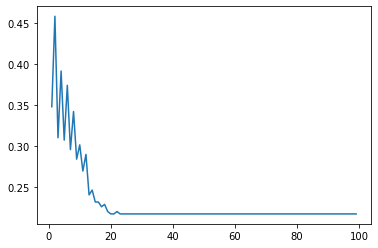

In [13]:
errors = []
for k in range(1,100):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    errors.append(np.mean(pred!=y_test))
plt.plot(range(1,100),errors)
plt.show()

In [14]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train,y_train)
print("K-Nearest Neighbours accuracy score: {}".format(accuracy_score(y_test, knn.predict(X_test))))

K-Nearest Neighbours accuracy score: 0.782608695652174


# <a id='Multinomial-Naive-Bayes' style="color:khaki">**Multinomial Naive Bayes**

In [15]:
MNB = MultinomialNB()
MNB.fit(X_train,y_train)
print("Multinomial Naive Bayes accuracy score: {}".format(accuracy_score(y_test, MNB.predict(X_test))))

Multinomial Naive Bayes accuracy score: 0.7652173913043478


# <a id='Complement-Naive-Bayes' style="color:khaki">**Complement Naive Bayes**

In [16]:
CNB = ComplementNB()
CNB.fit(X_train,y_train)
print("Complement Naive Bayes accuracy score: {}".format(accuracy_score(y_test, CNB.predict(X_test))))

Complement Naive Bayes accuracy score: 0.7652173913043478


# <a id='Word-Cloud' style="color:khaki">**Word Cloud**

A Wordcloud is a visual representation of text data. It displays a list of words, the importance of each beeing shown with font size or color.

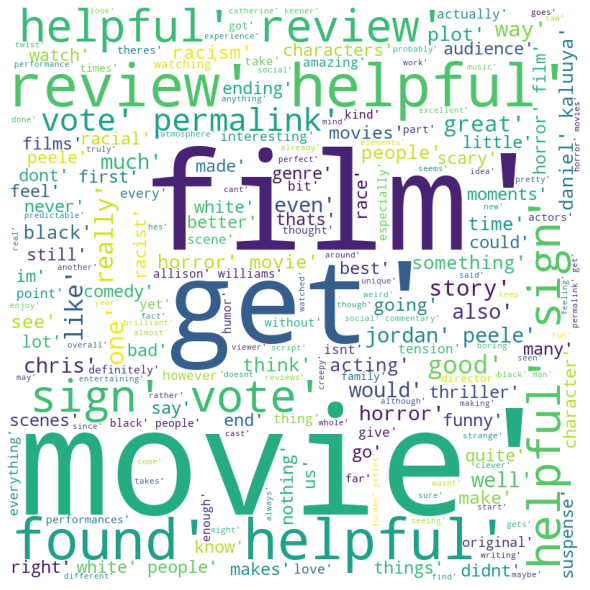

In [17]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      stopwords = stopwords,
                      min_font_size = 10).generate(' '.join(df['filtered']))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# <a id='Conclusion' style="color:khaki">**Conclusion**

Models with an average accuracy of 78% on a dataset of about 1600 proved to be more than good. The model would work even better on a larger dataset.
This project can be improved by adding XGBoost, and it would also be interesting to try TextBlob!
Please upvote this if you want to see how it would be to try XGBoost and TextBlob. :)